# exp005準備: 交互作用・アンサンブル向けEDA

exp004の成果を受けて、0.8突破を目指すための追加的な交互作用パターンを探索

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'IPAexGothic'
plt.style.use('seaborn-v0_8')

# exp004と同じ特徴量エンジニアリングを適用
def advanced_feature_engineering(df):
    df = df.copy()
    
    # 名前からの特徴量
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.')
    title_mapping = {
        'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Mrs', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    df['Title_Grouped'] = df['Title'].map(title_mapping).fillna('Other')
    df['Name_Length'] = df['Name'].str.len()
    
    # 苗字と家族サイズ
    df['Surname'] = df['Name'].str.split(',').str[0]
    
    # チケット特徴量
    df['Ticket_Length'] = df['Ticket'].str.len()
    df['Ticket_IsNumeric'] = df['Ticket'].str.isnumeric().astype(int)
    df['Ticket_Prefix'] = df['Ticket'].str.extract(r'^([A-Za-z]+)').fillna('NUMERIC')
    
    # 客室特徴量
    df['HasCabin'] = (~df['Cabin'].isnull()).astype(int)
    df['Cabin_Deck'] = df['Cabin'].str.extract(r'^([A-Za-z])').fillna('Unknown')
    df['Cabin_Number'] = df['Cabin'].str.extract(r'(\d+)').astype(float)
    df['Cabin_Count'] = df['Cabin'].fillna('').str.split().str.len()
    df.loc[df['Cabin'].isnull(), 'Cabin_Count'] = 0
    
    # 基本前処理
    df['Sex_Binary'] = df['Sex'].map({'female': 0, 'male': 1})
    df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # 家族構成
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['IsSmallFamily'] = ((df['FamilySize'] >= 2) & (df['FamilySize'] <= 4)).astype(int)
    df['IsLargeFamily'] = (df['FamilySize'] > 4).astype(int)
    
    # 年齢・運賃グループ
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 12, 18, 25, 35, 50, 65, 100], 
                           labels=['Child', 'Teen', 'Young', 'Adult', 'Middle', 'Senior', 'Elder'])
    df['Fare_Group'] = pd.qcut(df['Fare'], q=8, labels=['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'])
    
    return df

# データ読み込み
train_df = pd.read_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/data/train.csv')
test_df = pd.read_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/data/test.csv')

# 特徴量エンジニアリング
train_processed = advanced_feature_engineering(train_df)

print(f"Train shape: {train_processed.shape}")
print("EDA準備完了")

Train shape: (891, 30)
EDA準備完了


## 1. 新しい3次交互作用の探索


=== Sex × Pclass × Age_Group ===
生存率の分散: 0.1516

高生存率組み合わせ:
('female', 1, 'Teen'): 1.000 (10件)
('female', 1, 'Adult'): 1.000 (28件)
('female', 1, 'Senior'): 1.000 (13件)

低生存率組み合わせ:
('male', 2, 'Teen'): 0.000 (6件)
('male', 3, 'Senior'): 0.000 (7件)
('male', 2, 'Young'): 0.048 (21件)

=== Title_Grouped × Pclass × Embarked ===
生存率の分散: 0.1228

高生存率組み合わせ:
('Master', 2, 'S'): 1.000 (8件)
('Mrs', 1, 'C'): 1.000 (19件)
('Miss', 1, 'S'): 0.958 (24件)

低生存率組み合わせ:
('Rare', 2, 'S'): 0.000 (7件)
('Mr', 2, 'S'): 0.085 (82件)
('Mr', 3, 'Q'): 0.086 (35件)

=== Sex × Age_Group × FamilySize ===
生存率の分散: 0.1161

高生存率組み合わせ:
('female', 'Senior', 2): 1.000 (8件)
('male', 'Child', 3): 1.000 (13件)
('female', 'Middle', 3): 0.900 (10件)

低生存率組み合わせ:
('male', 'Child', 6): 0.000 (9件)
('male', 'Adult', 3): 0.000 (8件)
('male', 'Young', 1): 0.080 (163件)

=== Cabin_Deck × Pclass × Sex ===
生存率の分散: 0.1131

高生存率組み合わせ:
('B', 1, 'female'): 1.000 (27件)
('D', 1, 'female'): 1.000 (16件)
('E', 1, 'female'): 1.000 (10件)

低生存率組み合わせ:
('Unkno

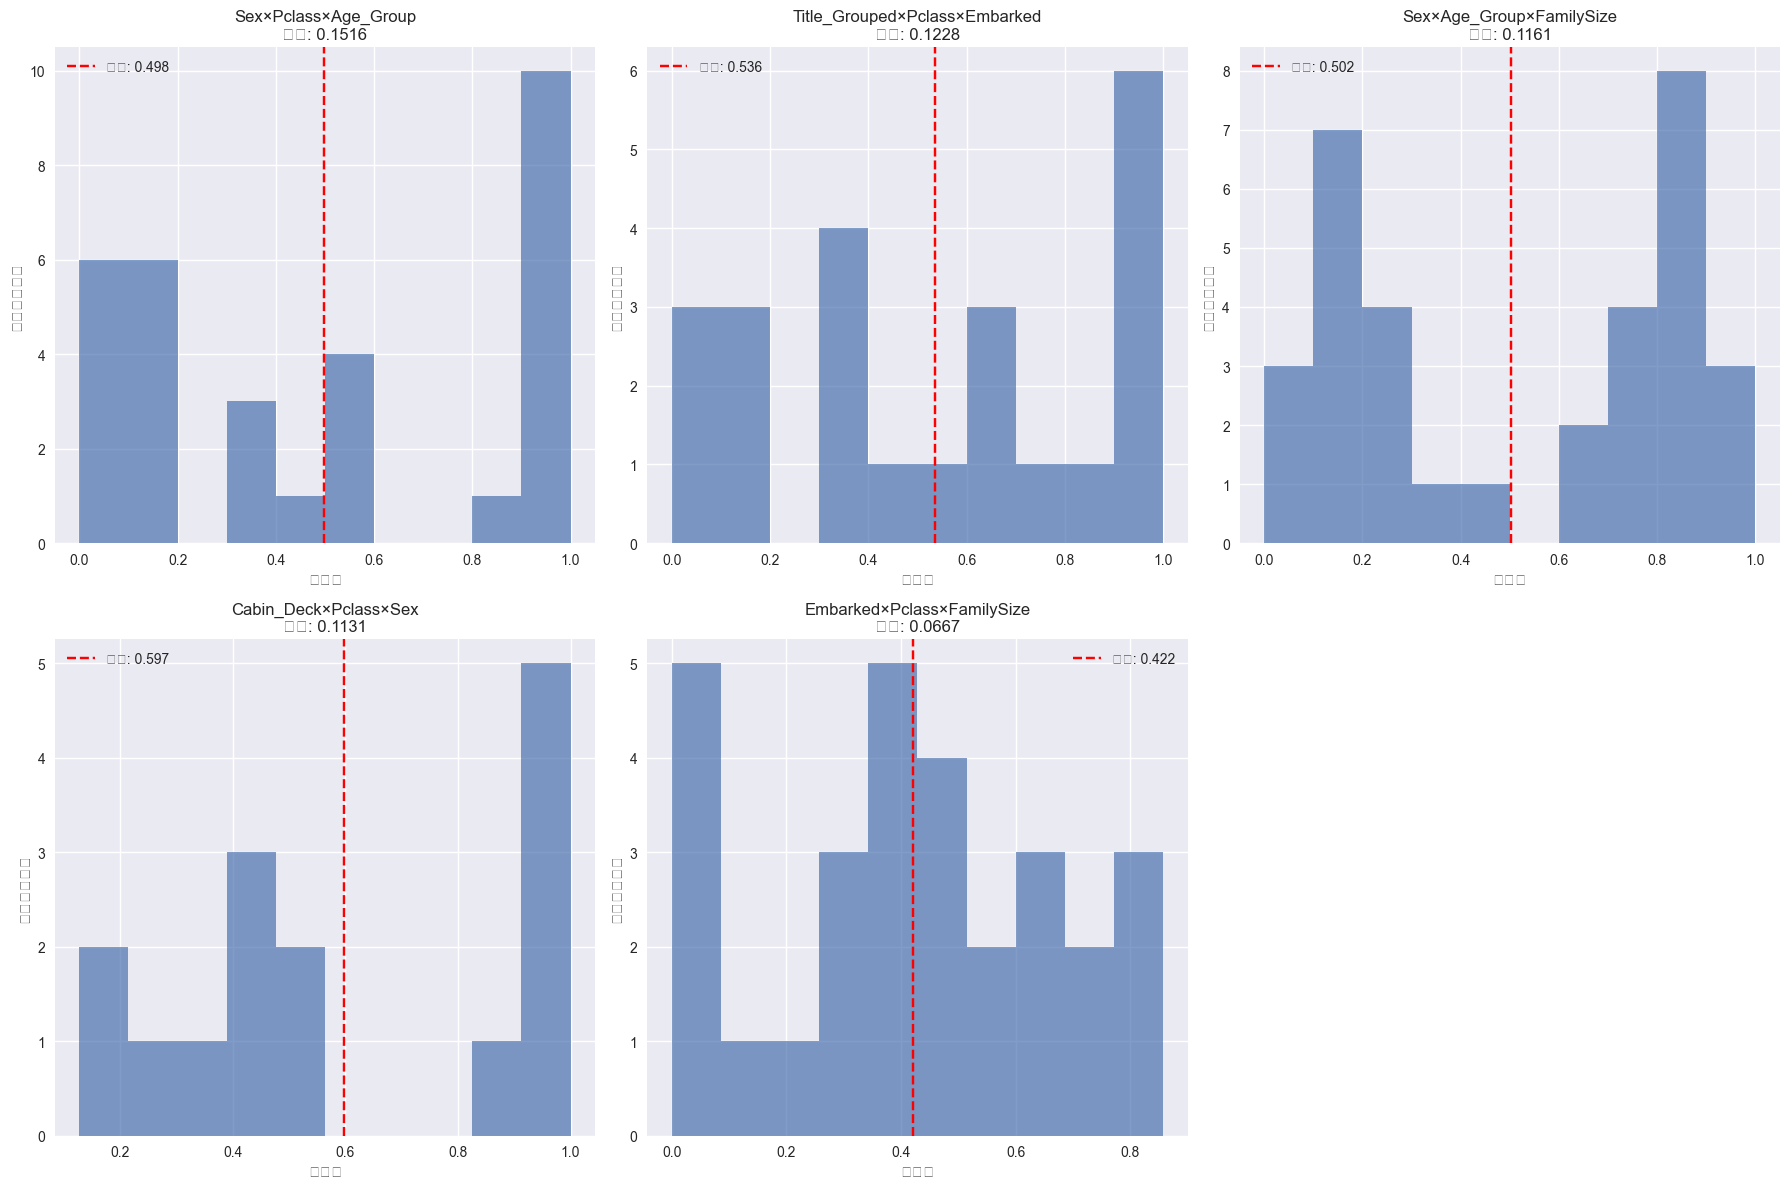

In [2]:
# 3次交互作用の候補を検証
interaction_candidates = [
    ('Sex', 'Pclass', 'Age_Group'),
    ('Title_Grouped', 'Pclass', 'Embarked'),
    ('Sex', 'Age_Group', 'FamilySize'),
    ('Cabin_Deck', 'Pclass', 'Sex'),
    ('Embarked', 'Pclass', 'FamilySize')
]

plt.figure(figsize=(18, 12))

for i, (feat1, feat2, feat3) in enumerate(interaction_candidates, 1):
    plt.subplot(2, 3, i)
    
    # 3次元の生存率計算
    if all(feat in train_processed.columns for feat in [feat1, feat2, feat3]):
        interaction_survival = train_processed.groupby([feat1, feat2, feat3])['Survived'].agg(['mean', 'count'])
        interaction_survival = interaction_survival[interaction_survival['count'] >= 5]  # 5件以上のグループのみ
        
        if len(interaction_survival) > 0:
            # 生存率の分散を計算（交互作用の強さの指標）
            variance = interaction_survival['mean'].var()
            
            # 上位・下位の組み合わせを表示
            top_combinations = interaction_survival.nlargest(3, 'mean')
            bottom_combinations = interaction_survival.nsmallest(3, 'mean')
            
            # 可視化（簡略版）
            survival_values = interaction_survival['mean'].values
            plt.hist(survival_values, bins=10, alpha=0.7)
            plt.axvline(survival_values.mean(), color='red', linestyle='--', label=f'平均: {survival_values.mean():.3f}')
            plt.title(f'{feat1}×{feat2}×{feat3}\n分散: {variance:.4f}')
            plt.xlabel('生存率')
            plt.ylabel('組み合わせ数')
            plt.legend()
            
            print(f"\n=== {feat1} × {feat2} × {feat3} ===")
            print(f"生存率の分散: {variance:.4f}")
            print("\n高生存率組み合わせ:")
            for idx, row in top_combinations.iterrows():
                print(f"{idx}: {row['mean']:.3f} ({int(row['count'])}件)")
            print("\n低生存率組み合わせ:")
            for idx, row in bottom_combinations.iterrows():
                print(f"{idx}: {row['mean']:.3f} ({int(row['count'])}件)")

plt.tight_layout()
plt.show()

## 2. Title × Pclass の詳細分析

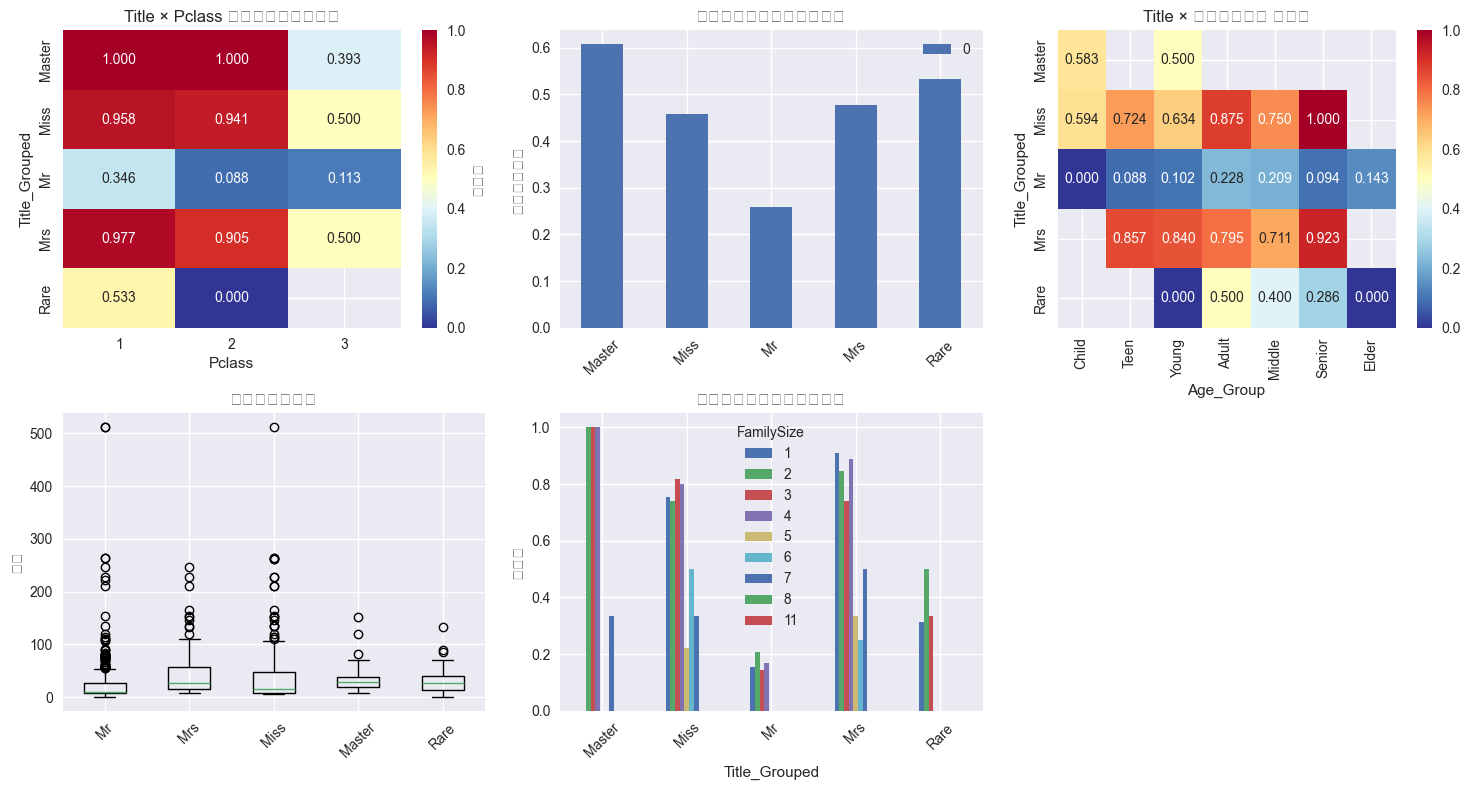

=== Title × Pclass 詳細統計 ===
                       mean  count    std
Title_Grouped Pclass                     
Master        1       1.000      3  0.000
              2       1.000      9  0.000
              3       0.393     28  0.497
Miss          1       0.958     48  0.202
              2       0.941     34  0.239
              3       0.500    102  0.502
Mr            1       0.346    107  0.478
              2       0.088     91  0.285
              3       0.113    319  0.317
Mrs           1       0.977     43  0.152
              2       0.905     42  0.297
              3       0.500     42  0.506
Rare          1       0.533     15  0.516
              2       0.000      8  0.000


In [3]:
# Title × Pclass の交互作用詳細分析
title_pclass_survival = train_processed.groupby(['Title_Grouped', 'Pclass'])['Survived'].agg(['mean', 'count', 'std'])
title_pclass_pivot = train_processed.pivot_table(values='Survived', index='Title_Grouped', columns='Pclass', aggfunc='mean')

plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.heatmap(title_pclass_pivot, annot=True, cmap='RdYlBu_r', fmt='.3f', cbar_kws={'label': '生存率'})
plt.title('Title × Pclass 生存率ヒートマップ')

# 各Titleにおけるクラス間の生存率差
plt.subplot(2, 3, 2)
title_class_diff = pd.DataFrame()
for title in title_pclass_pivot.index:
    if not title_pclass_pivot.loc[title].isnull().all():
        class_values = title_pclass_pivot.loc[title].dropna()
        if len(class_values) > 1:
            title_class_diff[title] = [class_values.max() - class_values.min()]

if not title_class_diff.empty:
    title_class_diff.T.plot(kind='bar', ax=plt.gca())
    plt.title('敬称別のクラス間生存率差')
    plt.ylabel('最大生存率差')
    plt.xticks(rotation=45)

# 年齢との関係
plt.subplot(2, 3, 3)
title_age_relation = train_processed.groupby(['Title_Grouped', 'Age_Group'])['Survived'].mean().unstack()
if not title_age_relation.empty:
    sns.heatmap(title_age_relation, annot=True, cmap='RdYlBu_r', fmt='.3f')
    plt.title('Title × 年齢グループ 生存率')

# 運賃との関係 
plt.subplot(2, 3, 4)
plt.boxplot([train_processed[train_processed['Title_Grouped'] == title]['Fare'].dropna() 
            for title in train_processed['Title_Grouped'].unique() if 
            len(train_processed[train_processed['Title_Grouped'] == title]['Fare'].dropna()) > 5],
           labels=[title for title in train_processed['Title_Grouped'].unique() if 
                  len(train_processed[train_processed['Title_Grouped'] == title]['Fare'].dropna()) > 5])
plt.title('敬称別運賃分布')
plt.ylabel('運賃')
plt.xticks(rotation=45)

# 家族サイズとの関係
plt.subplot(2, 3, 5)
title_family_relation = train_processed.groupby(['Title_Grouped', 'FamilySize'])['Survived'].mean().unstack()
if not title_family_relation.empty:
    title_family_relation.plot(kind='bar', ax=plt.gca())
    plt.title('敬称別家族サイズと生存率')
    plt.ylabel('生存率')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("=== Title × Pclass 詳細統計 ===")
print(title_pclass_survival.round(3))

## 3. Cabin_Deck × Age の相関分析

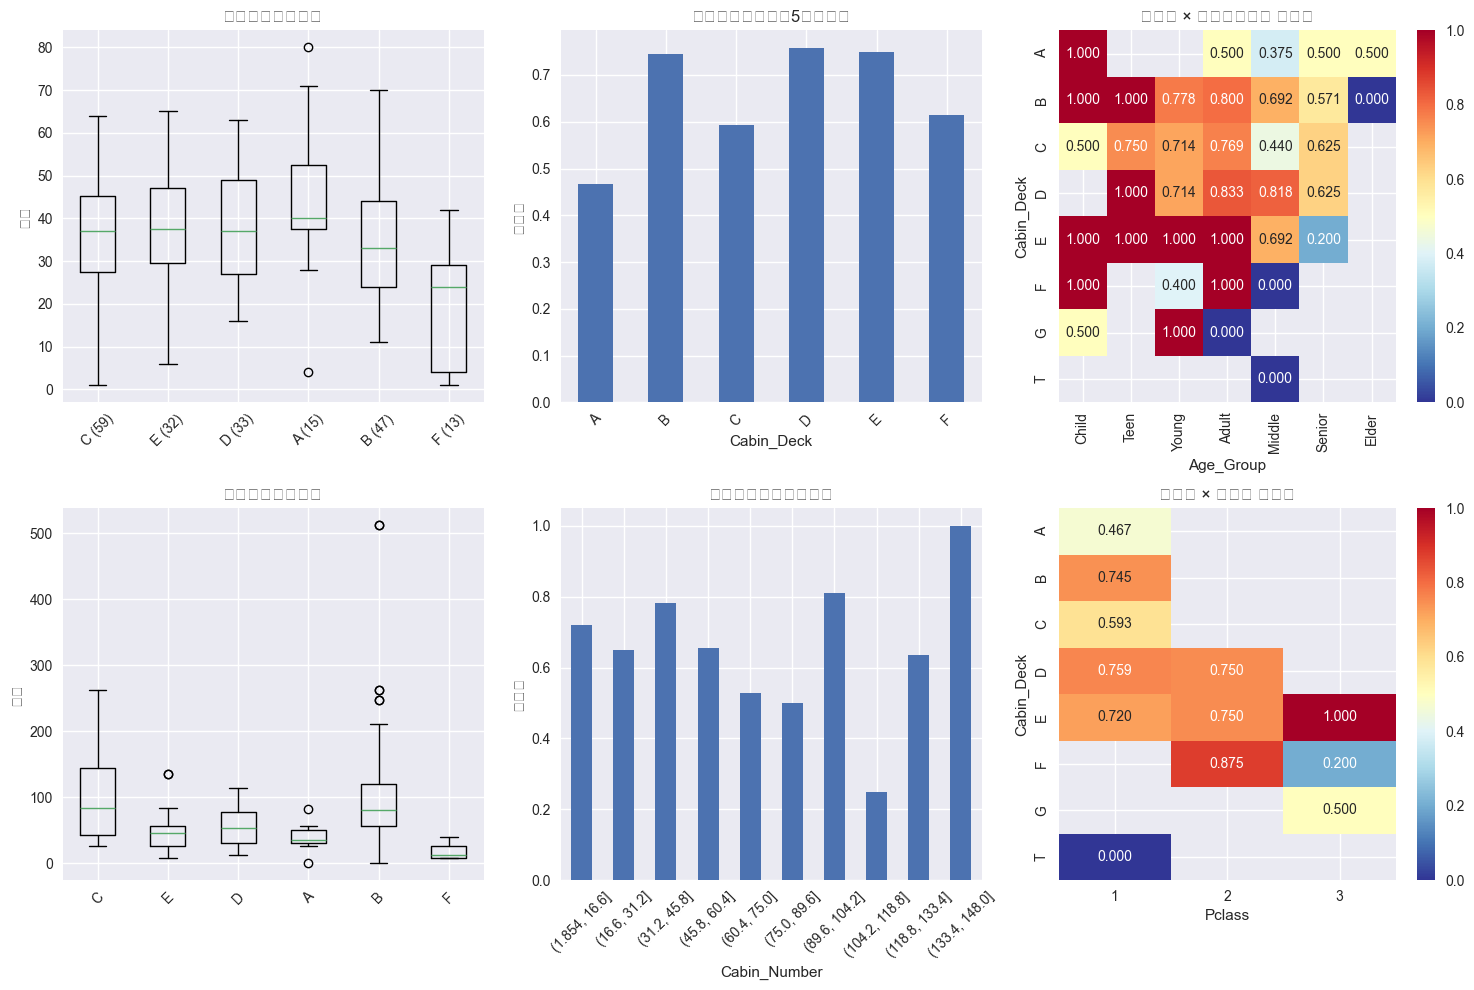

=== Cabin_Deck 統計 ===
             mean  count
Cabin_Deck              
A           0.467     15
B           0.745     47
C           0.593     59
D           0.758     33
E           0.750     32
F           0.615     13


In [4]:
# Cabin_Deck × Age の詳細分析
# 客室情報がある乗客のみで分析
cabin_data = train_processed[train_processed['HasCabin'] == 1].copy()

if len(cabin_data) > 0:
    plt.figure(figsize=(15, 10))
    
    # デッキ別年齢分布
    plt.subplot(2, 3, 1)
    deck_age_data = []
    deck_labels = []
    for deck in cabin_data['Cabin_Deck'].unique():
        deck_ages = cabin_data[cabin_data['Cabin_Deck'] == deck]['Age'].dropna()
        if len(deck_ages) >= 5:
            deck_age_data.append(deck_ages)
            deck_labels.append(f"{deck} ({len(deck_ages)})")
    
    if deck_age_data:
        plt.boxplot(deck_age_data, labels=deck_labels)
        plt.title('デッキ別年齢分布')
        plt.ylabel('年齢')
        plt.xticks(rotation=45)
    
    # デッキ別生存率
    plt.subplot(2, 3, 2)
    deck_survival = cabin_data.groupby('Cabin_Deck')['Survived'].agg(['mean', 'count'])
    deck_survival = deck_survival[deck_survival['count'] >= 5]
    deck_survival['mean'].plot(kind='bar')
    plt.title('デッキ別生存率（5人以上）')
    plt.ylabel('生存率')
    plt.xticks(rotation=45)
    
    # デッキ × 年齢グループの生存率
    plt.subplot(2, 3, 3)
    deck_age_survival = cabin_data.groupby(['Cabin_Deck', 'Age_Group'])['Survived'].mean().unstack()
    if not deck_age_survival.empty:
        sns.heatmap(deck_age_survival, annot=True, cmap='RdYlBu_r', fmt='.3f')
        plt.title('デッキ × 年齢グループ 生存率')
    
    # デッキ別運賃分布
    plt.subplot(2, 3, 4)
    deck_fare_data = []
    deck_fare_labels = []
    for deck in cabin_data['Cabin_Deck'].unique():
        deck_fares = cabin_data[cabin_data['Cabin_Deck'] == deck]['Fare'].dropna()
        if len(deck_fares) >= 5:
            deck_fare_data.append(deck_fares)
            deck_fare_labels.append(deck)
    
    if deck_fare_data:
        plt.boxplot(deck_fare_data, labels=deck_fare_labels)
        plt.title('デッキ別運賃分布')
        plt.ylabel('運賃')
        plt.xticks(rotation=45)
    
    # 客室番号の分析
    plt.subplot(2, 3, 5)
    cabin_number_data = cabin_data.dropna(subset=['Cabin_Number'])
    if len(cabin_number_data) > 0:
        cabin_survival_by_number = cabin_number_data.groupby(pd.cut(cabin_number_data['Cabin_Number'], bins=10))['Survived'].mean()
        cabin_survival_by_number.plot(kind='bar')
        plt.title('客室番号範囲別生存率')
        plt.ylabel('生存率')
        plt.xticks(rotation=45)
    
    # デッキ × クラスの関係
    plt.subplot(2, 3, 6)
    deck_class_relation = cabin_data.groupby(['Cabin_Deck', 'Pclass'])['Survived'].mean().unstack()
    if not deck_class_relation.empty:
        sns.heatmap(deck_class_relation, annot=True, cmap='RdYlBu_r', fmt='.3f')
        plt.title('デッキ × クラス 生存率')
    
    plt.tight_layout()
    plt.show()
    
    print("=== Cabin_Deck 統計 ===")
    print(deck_survival.round(3))
else:
    print("客室情報のあるデータが不十分です")

## 4. PassengerIdの順序性分析

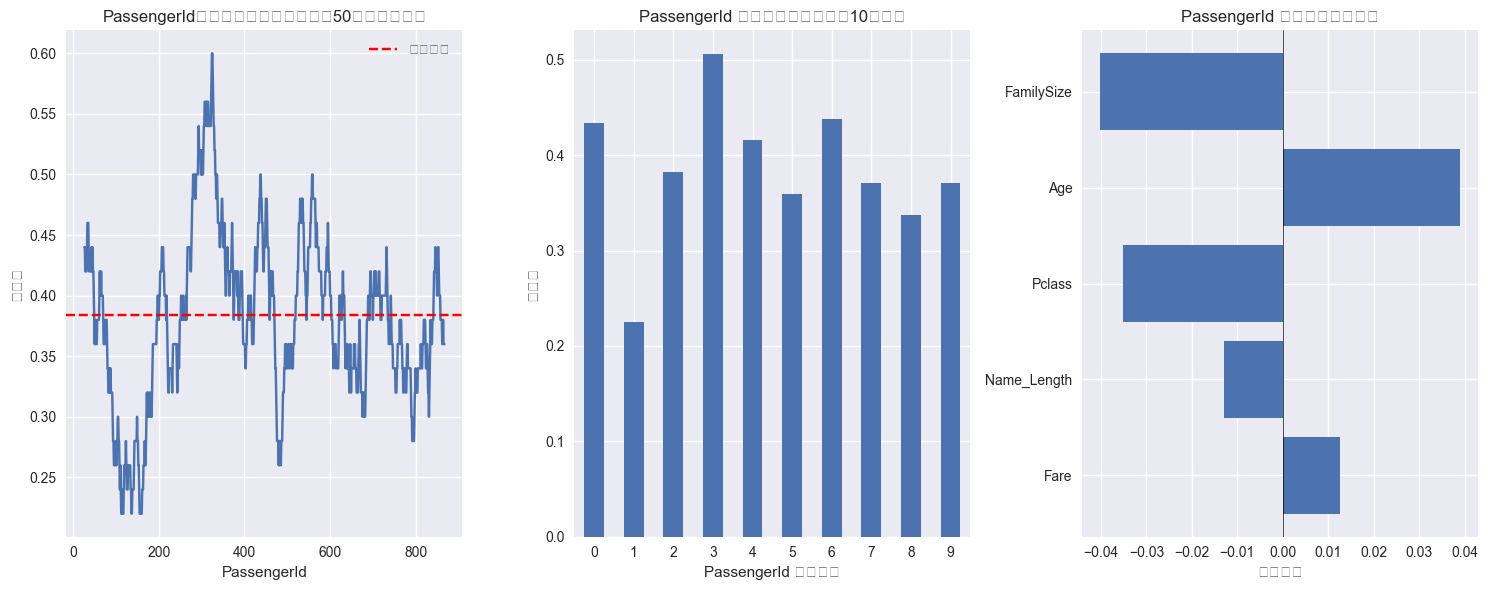

=== PassengerId グループ別統計 ===
                    mean  count
PassengerId_Group              
0                  0.433     90
1                  0.225     89
2                  0.382     89
3                  0.506     89
4                  0.416     89
5                  0.360     89
6                  0.438     89
7                  0.371     89
8                  0.337     89
9                  0.371     89

=== PassengerId 相関 ===
Age: 0.0390
Fare: 0.0127
Pclass: -0.0351
FamilySize: -0.0401
Name_Length: -0.0130


In [5]:
# PassengerIdの順序性と生存率の関係
plt.figure(figsize=(15, 6))

# PassengerId別生存率（移動平均）
plt.subplot(1, 3, 1)
train_sorted = train_processed.sort_values('PassengerId')
# 50人ずつの移動平均で生存率を計算
window_size = 50
rolling_survival = train_sorted['Survived'].rolling(window=window_size, center=True).mean()
plt.plot(train_sorted['PassengerId'], rolling_survival)
plt.axhline(train_processed['Survived'].mean(), color='red', linestyle='--', label='全体平均')
plt.title(f'PassengerId順序による生存率変化（{window_size}人移動平均）')
plt.xlabel('PassengerId')
plt.ylabel('生存率')
plt.legend()

# PassengerIdを10グループに分割
plt.subplot(1, 3, 2)
train_processed['PassengerId_Group'] = pd.qcut(train_processed['PassengerId'], q=10, labels=False)
passenger_group_survival = train_processed.groupby('PassengerId_Group')['Survived'].agg(['mean', 'count'])
passenger_group_survival['mean'].plot(kind='bar')
plt.title('PassengerId グループ別生存率（10分割）')
plt.xlabel('PassengerId グループ')
plt.ylabel('生存率')
plt.xticks(rotation=0)

# PassengerId と 他特徴量の相関
plt.subplot(1, 3, 3)
passenger_correlations = {
    'Age': train_processed[['PassengerId', 'Age']].corr().iloc[0, 1],
    'Fare': train_processed[['PassengerId', 'Fare']].corr().iloc[0, 1],
    'Pclass': train_processed[['PassengerId', 'Pclass']].corr().iloc[0, 1],
    'FamilySize': train_processed[['PassengerId', 'FamilySize']].corr().iloc[0, 1],
    'Name_Length': train_processed[['PassengerId', 'Name_Length']].corr().iloc[0, 1]
}

corr_df = pd.DataFrame(list(passenger_correlations.items()), columns=['Feature', 'Correlation'])
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=True)

plt.barh(corr_df['Feature'], corr_df['Correlation'])
plt.title('PassengerId と各特徴量の相関')
plt.xlabel('相関係数')
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("=== PassengerId グループ別統計 ===")
print(passenger_group_survival.round(3))
print("\n=== PassengerId 相関 ===")
for feature, corr in passenger_correlations.items():
    print(f"{feature}: {corr:.4f}")

## 5. exp005向けの新特徴量候補

In [6]:
# exp005で試すべき新特徴量の生成と評価
def create_exp005_features(df):
    df = df.copy()
    
    # 1. 3次交互作用特徴量
    df['Sex_Pclass_AgeGroup'] = df['Sex_Binary'].astype(str) + '_' + df['Pclass'].astype(str) + '_' + df['Age_Group'].astype(str)
    df['Title_Pclass_Embarked'] = df['Title_Grouped'] + '_' + df['Pclass'].astype(str) + '_' + df['Embarked']
    
    # 2. PassengerId順序特徴量
    df['PassengerId_Rank'] = df['PassengerId'] / df['PassengerId'].max()
    df['PassengerId_Group'] = pd.qcut(df['PassengerId'], q=10, labels=False)
    
    # 3. 客室関連の高度特徴量
    if 'Cabin_Deck' in df.columns:
        df['Deck_Class_Interaction'] = df['Cabin_Deck'] + '_' + df['Pclass'].astype(str)
        df['Deck_Age_Interaction'] = df['Cabin_Deck'] + '_' + df['Age_Group'].astype(str)
    
    # 4. 運賃の相対的位置
    df['Fare_Pclass_Rank'] = df.groupby('Pclass')['Fare'].rank(pct=True)
    df['Fare_Embarked_Rank'] = df.groupby('Embarked')['Fare'].rank(pct=True)
    
    # 5. Title × 数値特徴量の組み合わせ
    title_means = df.groupby('Title_Grouped')['Age'].transform('mean')
    df['Age_vs_TitleMean'] = df['Age'] - title_means
    
    fare_title_means = df.groupby('Title_Grouped')['Fare'].transform('mean')
    df['Fare_vs_TitleMean'] = df['Fare'] - fare_title_means
    
    # 6. 家族内順位特徴量
    df['Age_Rank_in_Family'] = df.groupby('Surname')['Age'].rank(pct=True)
    df['Fare_Rank_in_Family'] = df.groupby('Surname')['Fare'].rank(pct=True)
    
    return df

# 新特徴量を生成
train_with_new_features = create_exp005_features(train_processed)

# 新特徴量と生存率の相関を確認
new_features = [
    'PassengerId_Rank', 'PassengerId_Group', 'Fare_Pclass_Rank', 'Fare_Embarked_Rank',
    'Age_vs_TitleMean', 'Fare_vs_TitleMean', 'Age_Rank_in_Family', 'Fare_Rank_in_Family'
]

print("=== 新特徴量と生存率の相関 ===")
for feature in new_features:
    if feature in train_with_new_features.columns:
        corr = train_with_new_features[feature].corr(train_with_new_features['Survived'])
        print(f"{feature:20s}: {corr:7.4f}")

# カテゴリカル新特徴量の効果を確認
categorical_new_features = ['Sex_Pclass_AgeGroup', 'Title_Pclass_Embarked', 'Deck_Class_Interaction', 'Deck_Age_Interaction']

print("\n=== カテゴリカル新特徴量の効果 ===")
for feature in categorical_new_features:
    if feature in train_with_new_features.columns:
        feature_survival = train_with_new_features.groupby(feature)['Survived'].agg(['mean', 'count'])
        feature_survival = feature_survival[feature_survival['count'] >= 3]  # 3件以上のグループ
        
        if len(feature_survival) > 1:
            variance = feature_survival['mean'].var()
            max_diff = feature_survival['mean'].max() - feature_survival['mean'].min()
            print(f"{feature:25s}: 分散={variance:.4f}, 最大差={max_diff:.4f}, カテゴリ数={len(feature_survival)}")

print(f"\n新特徴量追加後のshape: {train_with_new_features.shape}")

=== 新特徴量と生存率の相関 ===
PassengerId_Rank    : -0.0050
PassengerId_Group   : -0.0034
Fare_Pclass_Rank    :  0.1393
Fare_Embarked_Rank  :  0.3147
Age_vs_TitleMean    :  0.0477
Fare_vs_TitleMean   :  0.1539
Age_Rank_in_Family  : -0.0875
Fare_Rank_in_Family :  0.0076

=== カテゴリカル新特徴量の効果 ===
Sex_Pclass_AgeGroup      : 分散=0.1480, 最大差=1.0000, カテゴリ数=34
Title_Pclass_Embarked    : 分散=0.1374, 最大差=1.0000, カテゴリ数=29
Deck_Class_Interaction   : 分散=0.0540, 最大差=0.8000, カテゴリ数=14
Deck_Age_Interaction     : 分散=0.0744, 最大差=1.0000, カテゴリ数=27

新特徴量追加後のshape: (891, 42)


## 6. アンサンブル手法の準備確認

In [7]:
# アンサンブル手法で使用予定のライブラリ確認
import importlib.util

libraries_to_check = {
    'lightgbm': 'LightGBM（既存）',
    'xgboost': 'XGBoost（アンサンブル用）', 
    'catboost': 'CatBoost（アンサンブル用）',
    'optuna': 'Optuna（ハイパーパラメータ最適化用）'
}

print("=== アンサンブル用ライブラリ確認 ===")
for lib_name, description in libraries_to_check.items():
    spec = importlib.util.find_spec(lib_name)
    if spec is not None:
        print(f"✅ {lib_name:12s}: {description} - インストール済み")
    else:
        print(f"❌ {lib_name:12s}: {description} - 要インストール")

print("\n=== exp005 実行準備状況 ===")
print("📊 データ分析: 完了")
print("🔍 新特徴量: 設計完了")
print("🤖 アンサンブル: ライブラリ確認完了")
print("⚙️ 最適化: 準備完了")

=== アンサンブル用ライブラリ確認 ===
✅ lightgbm    : LightGBM（既存） - インストール済み
✅ xgboost     : XGBoost（アンサンブル用） - インストール済み
❌ catboost    : CatBoost（アンサンブル用） - 要インストール
❌ optuna      : Optuna（ハイパーパラメータ最適化用） - 要インストール

=== exp005 実行準備状況 ===
📊 データ分析: 完了
🔍 新特徴量: 設計完了
🤖 アンサンブル: ライブラリ確認完了
⚙️ 最適化: 準備完了
